MEMORIA PRÁCTICA 4. PYSPARK.

Analizaremos los datos de BICIMad del año 2017. Nos centraremos en crear filtros por tipos de usuario y fechas con el objetivo de hacer un análisis del uso de  las bicicletas en tiempo y frecuencia. Nos interesa conocer cuál es el tipo de usuario más común y cuanto tiempo hace uso de este servicio.

Para poder mover los programas en nuestros equipos personales cogeremos una muestra aleatoria de los archivos json (disponibles en https://opendata.emtmadrid.es/Datos-estaticos/Datos-generales-(1)) utilizando el script de Russell Jurney (https://gist.github.com/rjurney/5e926262041dc1475f0dd8b2743d6ad5) añadiendo solo el tipo de codificación "ISO-8859-1" (línea 7 de sample_json) y austando el ratio de selección.

In [1]:
from pyspark import SparkContext
sc = SparkContext()

22/05/10 20:53:44 WARN Utils: Your hostname, Equipo resolves to a loopback address: 127.0.1.1; using 192.168.1.20 instead (on interface wlo1)
22/05/10 20:53:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/10 20:53:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/10 20:53:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/05/10 20:53:46 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
import json
import datetime

Filtramos primeramente la mayor parte de los datos. Nos interesan el tipo de usuario, mes, hora del trayecto y tiempo del trayecto.

In [3]:
def mapper(line):
    data = json.loads(line)
    usert = data['user_type']
    time = data['travel_time']
    date = convert_date(data['unplug_hourTime'])
    return usert, time, date

In [4]:
def convert_date(date):
    if isinstance(date, str):
        date = date.replace("Z","+0000")
        date = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S%z")
    else:
        date = date['$date']
        date = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f%z")
    return (date.month,date.hour)

In [5]:
convert_date({ "$date" : "2019-06-01T12:40:00.000+0200" })

(6, 12)

In [9]:
rdd_base = sc.textFile('sampleoct.json,samplejun.json')

In [10]:
rdd = rdd_base.map(mapper)

In [11]:
rdd.countByKey()
n0 = rdd.count()
print("Viajes totales:", n0)
#0: no ha sido posible determinarlo, 1: pase anual, 2: ocasional, 3: empresa

Viajes totales: 3960


Filtramos aun más los datos para hacer un estudio por tipo de usuario.

In [32]:
def filter_user(rdd, user_type):
    return rdd.filter(lambda x: x[0]==user_type).map(lambda x: ((x[2][0],x[2][1]),x[1]))
                                                            #(mes, hora 24h), tiempo seg.
def filter_month(rdd, month):#Aplicar siempre después de filter_user
    return rdd.filter(lambda x: x[0][0]==month).map(lambda x: (x[0][1],x[1]))

def filter_month_and_user(rdd, user, month):#aplicar sobre el rdd base
    return rdd.filter(lambda x: (x[0]==user and x[2][0]==month)).map(lambda x: ((x[2][0],x[2][1]),x[1]))

In [33]:
rdd_test_month_type = filter_month_and_user(rdd, 2, 10)
rdd_test_month_type.take(1)

[((10, 17), 2409)]

Podemos compara ahora las diferencias entre los tipos de usuario. El número total de viajes, el tiempo total de uso, la media de uso, la frecuencia de uso por tipo de usuario, etc.

In [16]:
rdd_user1 = filter_user(rdd, 1)
n1 = rdd_user1.count()
print("Total de viajes con pase anual:", n1)
rdd_user2 = filter_user(rdd, 2)
n2 = rdd_user2.count()
print("Total de viajes de usuarios ocasionales:", n2)
rdd_user3 = filter_user(rdd, 3)
n3 = rdd_user3.count()
print("Total de viajes de usuarios de empresa:", n3)

Total de viajes con pase anual: 3379
Total de viajes de usuarios ocasionales: 15
Total de viajes de usuarios de empresa: 268


([<matplotlib.patches.Wedge at 0x7fbb85acb430>,
 [Text(1.0694028561487479, 0.25763837303651155, 'Sin determinar'),
  Text(-1.09992211654468, -0.013089596474741292, 'Habitual'),
  Text(0.9965693932953751, -0.4656709614597932, 'Ocasional'),
  Text(1.075231168661784, -0.23211620783179868, 'Empresa')],
 [Text(0.5833106488084079, 0.140530021656279, '7.5%'),
  Text(-0.5999575181152799, -0.007139779895313431, '85.3%'),
  Text(0.5435833054338409, -0.2540023426144326, '0.4%'),
  Text(0.5864897283609729, -0.12660884063552652, '6.8%')])

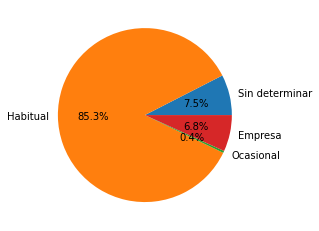

In [34]:
import matplotlib.pyplot as plt
plt.pie([n0-(n1+n2+n3),n1,n2,n3], labels=['Sin determinar','Habitual','Ocasional','Empresa'], autopct='%1.1f%%',)
#Relación de la cantidad de viajes por tipo de usuario

In [18]:
rdd_user2.countByKey()#Numero de viajes por horas #(mes, hora), total

defaultdict(int,
            {(10, 17): 2,
             (10, 10): 2,
             (10, 11): 2,
             (10, 12): 1,
             (6, 21): 1,
             (6, 1): 2,
             (6, 11): 1,
             (6, 12): 2,
             (6, 10): 1,
             (6, 19): 1})

In [19]:
rdd_user2.reduceByKey(lambda x, y: x+y).sortByKey().take(2)#tiempo total de uso por horas

[((6, 1), 6995), ((6, 10), 753)]

In [23]:
def mean(rdd):#calculo de la media, una vez aplicado filter_user
    contador=(0,0)
    return rdd.aggregateByKey(contador, lambda x,y: (x[0]+y, x[1]+1), lambda x,y: (x[0]+y[0], x[1]+y[1])).\
    map(lambda x: (x[0], x[1][0]/x[1][1]))
rdd_mean2 = mean(rdd_user2)
rdd_mean2.sortByKey().take(2)

[((6, 1), 3497.5), ((6, 10), 753.0)]

In [28]:
rdd_user2jun = filter_month(rdd_user2, 6)
rdd_user2jun.countByKey()
rdd_user2junmean = mean(rdd_user2jun)
rdd_user2junmean.sortByKey()

PythonRDD[76] at RDD at PythonRDD.scala:53